In [1]:
include("src/config.jl")
include("src/load.jl")
include("src/plotutils.jl")

ripley_plot! (generic function with 1 method)

In [2]:
# loading results
df, converged=load_results(; epsilons=config.epsilons, path=config.simpath);

In [3]:
conditionlabels = zip(romanenum, map(x-> x=="none" ? "no influence" : x, config.conditionorder)) .|> ((r, c),) -> "$(r) $(c)";

# Converged after

In [4]:
converged

Row,condition,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3
,String,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,initial,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,even,150.0,150.0,150.0,150.0,200.0,200.0,150.0,150.0,200.0,150.0,200.0,150.0,150.0,200.0,150.0,250.0,150.0,150.0,150.0,150.0,150.0,200.0,200.0,150.0,150.0,150.0
3,none,1850.0,900.0,950.0,600.0,750.0,600.0,1100.0,750.0,1600.0,2000.0,1300.0,1350.0,2400.0,1550.0,3350.0,1250.0,4150.0,1500.0,1050.0,950.0,1250.0,4800.0,3000.0,3850.0,5800.0,2000.0
4,few,1350.0,550.0,1100.0,700.0,1050.0,1500.0,750.0,450.0,350.0,550.0,300.0,350.0,150.0,150.0,150.0,150.0,150.0,150.0,200.0,200.0,200.0,150.0,200.0,200.0,200.0,200.0
5,shifted,750.0,550.0,750.0,1600.0,450.0,1150.0,500.0,750.0,250.0,700.0,1450.0,700.0,700.0,400.0,450.0,850.0,200.0,200.0,300.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0
6,biased,500.0,650.0,300.0,150.0,200.0,200.0,150.0,200.0,250.0,150.0,250.0,150.0,150.0,150.0,200.0,150.0,150.0,150.0,150.0,200.0,200.0,150.0,150.0,150.0,150.0,150.0


In [5]:
eachrow(converged[:, Not(:condition)]) |> maximum |> maximum

5800.0

# Figures

## Figure 2: alpha, beta distribution by epsilon

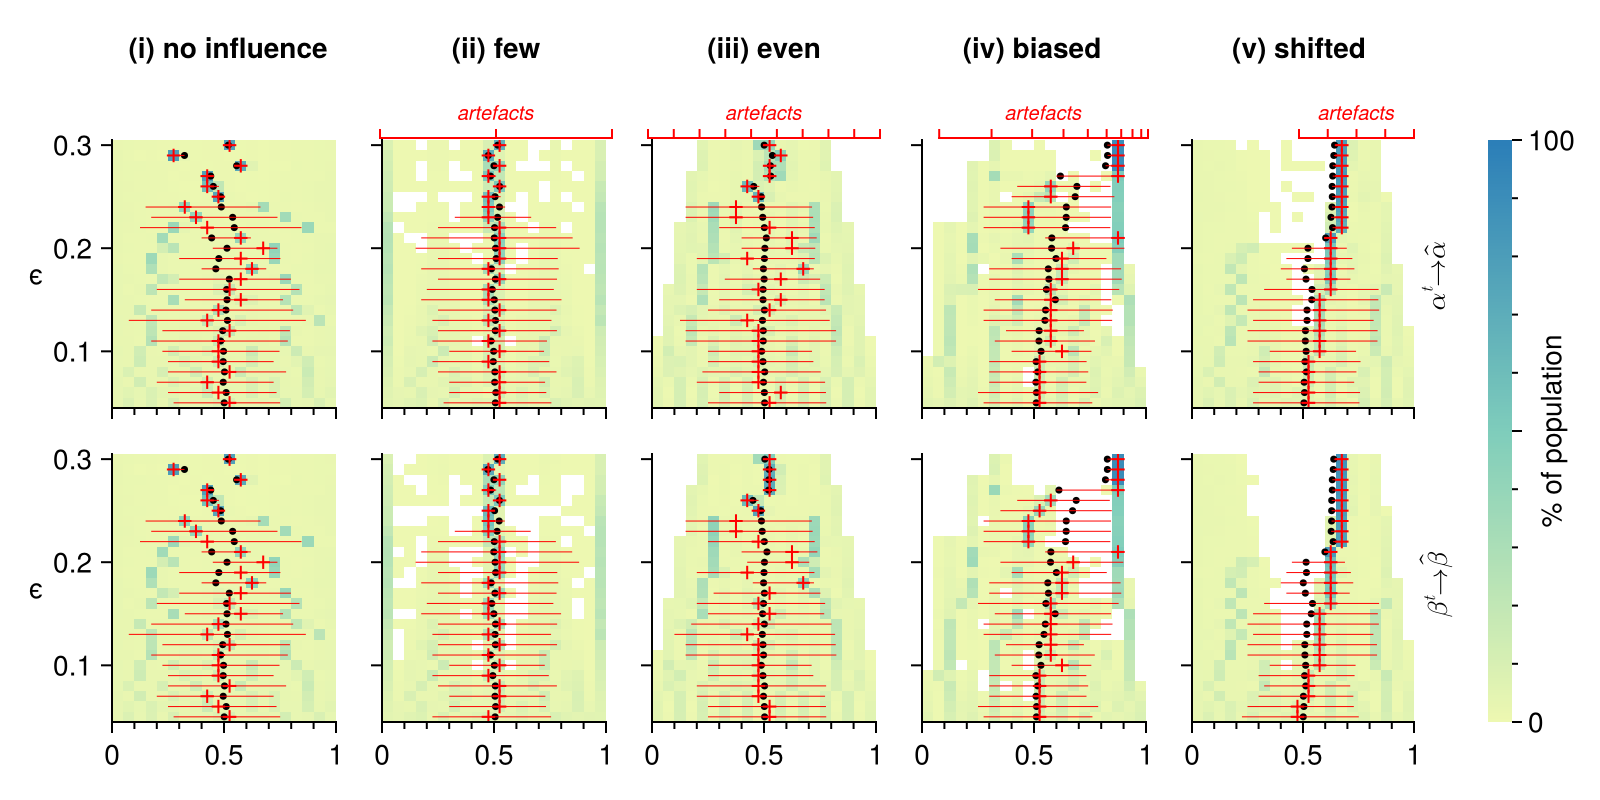

In [24]:
bins=0:.05:1
df.bins = convert.(Float64, cut(df.value, bins, extend=true, labels=round.(bins[1:end-1] .+ .025, digits=3)))

fig = simheatmap!(df;
    y=:epsilon, x=:bins,
    row=:type,
    col=:condition,
    colorder=config.conditionorder,
    roworder=[:alpha, :beta],
    artefacts=config.conditions,
    titles = conditionlabels
)
save(joinpath(config.figpath,"heatmap.eps"), fig)
fig

## Figure 3: Ripley's K/L/H

In [7]:
# ripley's L
using Distances
        
area(args...) = abs(reduce(*, map(i-> sum(i.* [-1,1]), extrema.(args))))

function ripleyk!(α, β, radii; n = length(α), dmat = zeros(n,n), k = zeros(Int, length(radii)), dist)
    dmat .= pairwise(dist, zip(α, β), zip(α, β))
    for j in 1:n, i in 1:j-1
        k .+= radii .> dmat[i,j]
    end
    k .= k.*2 ./ n^2 * area(α, β)
end

function ripleyl!(α, β, radii; n = length(α), dmat = zeros(n,n), k = zeros(length(radii)), dist=euclidean, linearized=true)
    ripleyk!(α, β, radii; n, dmat, k, dist=euclidean)
    k .= sqrt.(k ./π)
    linearized && k .= k .- radii
    k
end

radii = 0:.01:.5
epsilons = [.1, .15, .3]
dmat = zeros(config.N, config.N);
ripleyldf = combine(groupby(df[df.epsilon .∈ Ref(epsilons), :], [:condition, :epsilon]), [:type, :value] => ((t,v) -> [ripleyl!(v[t.==:alpha], v[t.==:beta], radii; n=config.N, dmat)]) => string.(radii));

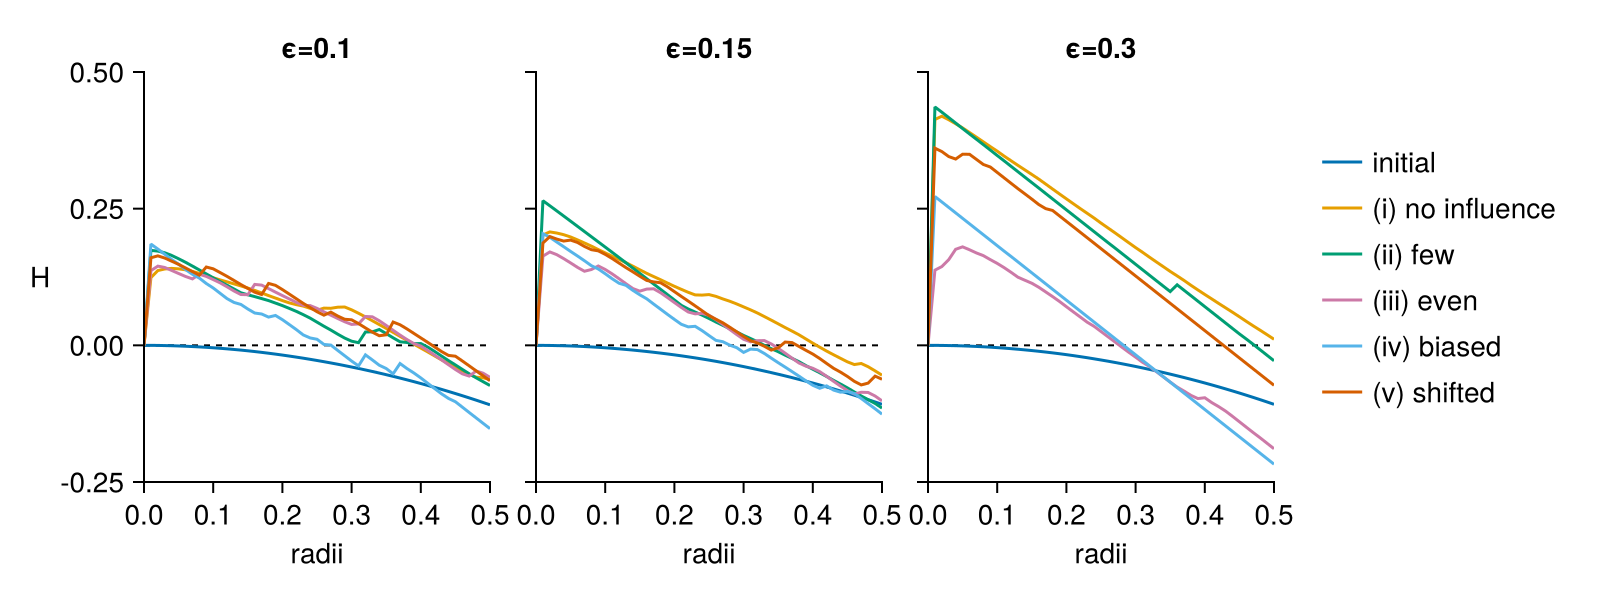

In [23]:
# ripley's l plot
fig = ripley_plot!(
    ripleyldf; 
    col=:epsilon, colorder=[.1, .15, .3], 
    hue=:condition, hueorder=["initial", config.conditionorder...], 
    labels = ["initial", conditionlabels...]
)
save(joinpath(config.figpath, "ripley.eps"), fig)
fig

# Tables

In [9]:
# Latex table Setup
using Formatting, PrettyTables, HypothesisTests, Distributions

function chopformatter(v, i, j; chopleadingzerocols=nothing, colformats=[[1]=>"%.2f", pvalcolnrs=>"%.3f", uvalcolnrs=>"%d"])
    isnothing(v) && return "" 
    v isa Real && v < .001 && return "< .001"
    res = v
    fmtidx = findfirst(cols-> j ∈ cols, first.(colformats))
    if !isnothing(fmtidx); res = sprintf1(last(colformats[fmtidx]), v); end
    if j ∈ chopleadingzerocols; res = chopprefix(string.(res), "0"); end
    res
end

tf=LatexTableFormat(
    top_line="\\toprule",
    header_line="\\midrule",
    bottom_line="\\bottomrule",
    left_vline     = "",
    mid_vline      = "",
    right_vline    = "",
    header_envs=[], subheader_envs=[],
)

LatexTableFormat("\\toprule", "\\midrule", "\\hline", "\\bottomrule", "", "", "", String[], String[], [:begin, :header, :end], :none, :tabular, true, "table")

## Table 3: Occupied space, mean, std

In [12]:
# occupied space 
function occupied_space(a; bins=0:.01:1)
    xbins = unwrap.(cut(a, bins, extend=true, labels=bins[1:end-1]))
    sum(bins .∈ Ref(xbins)) / (length(bins)-1)
end

statsdf = combine(
    groupby(df, [:condition, :epsilon]), 
    [:type, :value] => ((t,v) -> [Ref(hcat([v[t.==tt] for tt in unique(t)]...)) .|> [occupied_space, mean, std]]) => [:occupied, :mean, :std]);

In [13]:
groups = groupby(statsdf, :condition)
statsjoind = innerjoin([rename(groups[(condition=c,)][:, Not(:condition)], Dict(m=>Symbol("$(m), $(c)") for m=[:mean, :std, :occupied])) for c in config.conditionorder]..., on=:epsilon);

In [14]:
n = size(statsjoind,2)
meanstdcolnrs = findall(x->occursin(r"mean|std", x), names(statsjoind))

open(joinpath(config.tabpath, "stats.tex"), "w") do io
    pretty_table(
        io,
        statsjoind;
        backend = Val(:latex), tf, wrap_table=false, 
        formatters = (v,i,j) -> chopformatter(
            v,i,j; 
            chopleadingzerocols=filter(∉(meanstdcolnrs), 1:n), 
            colformats=[filter(∉(meanstdcolnrs), 1:n)=>"%.2f", meanstdcolnrs=>"%.3f"]))
end

## Normality

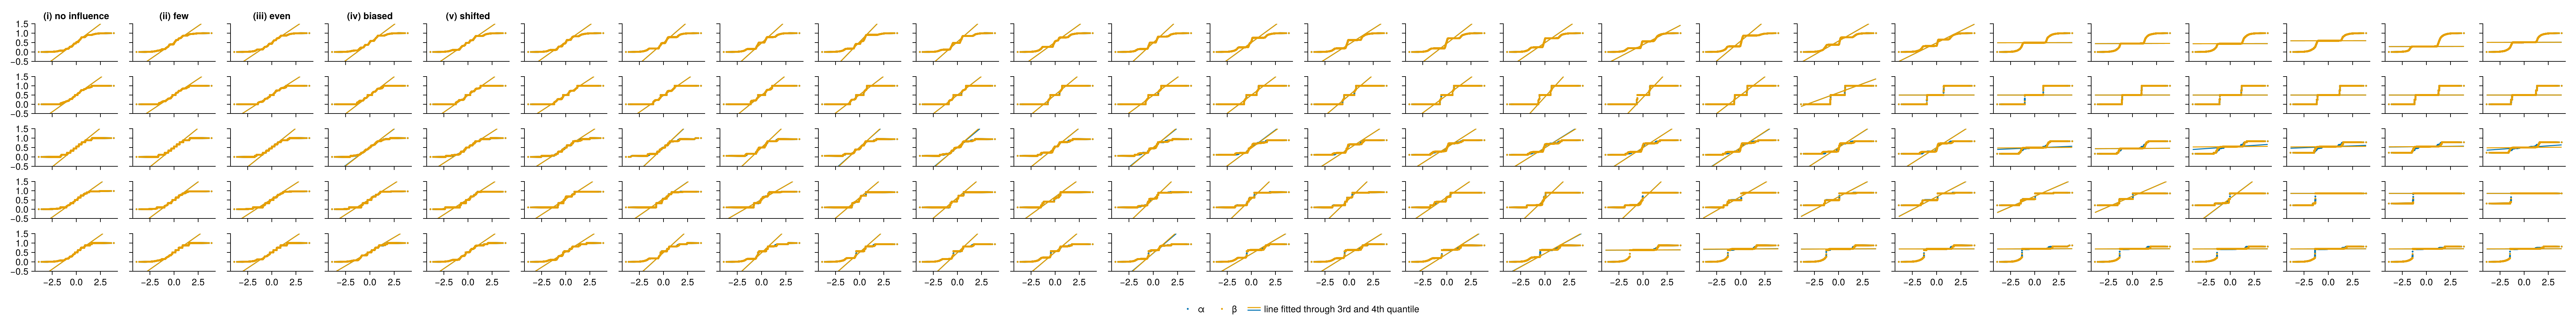

In [144]:

function qqfacet(
    df;
    x, hue, row, col,
    roworder=unique(df[:, row]),
    colorder=unique(df[:, col]),
    hueorder=unique(df[:, hue]), 
    huelabels=string.(hueorder),
    axargs = (
        xgridvisible=false, ygridvisible=false, topspinevisible=false, rightspinevisible=false,
        limits=(nothing, nothing, -.5, 1.5)
    ),
    colors=Makie.wong_colors(),
    fig = Figure(size=(150*length(colorder), 100*length(roworder))),
    titles = colorder,
)

    xlayout = GridLayout(fig[:, :])
    df_grouped = groupby(df, [col, row])

    axes = Array{Any}(undef, length(roworder), length(colorder))
    for (j,c) = enumerate(colorder)
        for (i,r) = enumerate(roworder)
            dg = df_grouped[Dict(row => r, col => c)]
            ax = axes[i,j] =Axis(xlayout[i,j]; axargs...)
            for (h, color)=zip(hueorder, colors)
                qqnorm!(ax, dg[dg[:, hue] .== h, x]; qqline = :fitrobust, markersize=4, color)
            end
        end
    end
    
    linkaxes!(axes...)
    
    for (ax,title) in zip(axes[1, :], titles); ax.title=title; end
    for ax in axes[1:end-1, :]; ax.xticklabelsvisible=false; end
    for ax in axes[:, 2:end]; ax.yticklabelsvisible=false; ax.ylabelvisible=false; end

    line = [LineElement(; color, points=Point2f[(0,i), (1,i)]) for (i, color) in zip((.4, .6), colors[1:length(hueorder)])]
    markers = [MarkerElement(; color, marker = :circle, markersize = 4) for color in colors[1:length(hueorder)]]
    
    Legend(
        fig[end+1, :], [markers..., line], [huelabels..., "line fitted through 3rd and 4th quantile"], 
        framevisible = false, tellheight=true; tellwidth = false, orientation = :horizontal
    )
    fig
end


fig = qqfacet(df;
    x=:value,
    hue=:type,
    row=:condition,
    roworder=config.conditionorder,
    hueorder=[:alpha, :beta],
    huelabels=["α", "β"],
    col=:epsilon,
    colorder=config.epsilons,
    titles = conditionlabels
)
fig

The data is quite obviously not normally disitributed, even judging visually. 

Testsing using Jarque Bera:

In [16]:
jbdf = combine(groupby(df, [:epsilon, :condition, :type]),  :value => (a-> begin
    t = JarqueBeraTest(a, adjusted=true);
    (statistic = t.JB, pvalue=pvalue(t))
end) => AsTable)

Row,epsilon,condition,type,statistic,pvalue
,Float64,String,Symbol,Float64,Float64
1,0.05,initial,alpha,629.273,2.26514e-137
2,0.05,initial,beta,602.699,1.33536e-131
3,0.05,even,alpha,578.456,2.45422e-126
4,0.05,even,beta,578.598,2.28567e-126
5,0.05,none,alpha,691.174,8.1941e-151
6,0.05,none,beta,691.174,8.1941e-151
7,0.05,few,alpha,622.38,7.10994e-136
8,0.05,few,beta,622.519,6.63405e-136
9,0.05,shifted,alpha,628.725,2.97899e-137


In [17]:
jbdf[jbdf.pvalue .> .05, 1:end]

Row,epsilon,condition,type,statistic,pvalue
,Float64,String,Symbol,Float64,Float64
1,0.25,few,alpha,1.35552,0.507753
2,0.25,few,beta,1.2137,0.545064


Using Anderson Darling

In [18]:
ad = combine(
    groupby(df, [:epsilon, :condition, :type]),  
    :value => (a -> begin
    t = OneSampleADTest(a, Normal(mean(a), std(a)));
    (A²=t.A², pvalue=pvalue(t))
end) => AsTable)

maximum(ad.pvalue)

5.999999996841865e-8

## Comparing group means

Testing difference/sameness of distributions using Mann-Whitney U since neither alpha nor beta are normally distributed.

In [19]:
ks = combine(
    groupby(df[df.condition .!= "initial", 1:end], [:epsilon]), 
    [:condition, :type, :value] => ((c,t,a) -> begin
        l = [:alpha, :beta] .|> tt -> KruskalWallisTest([a[(c.== cc) .& (t.==tt)] for cc in config.conditionorder]...) |> i-> [i.H, pvalue(i)]
        [collect(Iterators.flatten(l))]
    end) => ["H.alpha", "pvalue.alpha", "H.beta", "pvalue.beta"]);

In [20]:
# MWU tests
headers = reduce(vcat, Symbol.(Ref(c), [" U", " two-tailed", " left-tailed"]) for c in config.conditionorder[2:end])

mwu = combine(
    groupby(df[df.type .== :beta, 1:end], :epsilon), 
    [:condition, :value] => ((c, a) -> begin
        anoinfl = a[c .== first(config.conditionorder)]
        grps = [a[c.== cc] for cc in config.conditionorder[2:end]]
        l = [reduce(vcat, MannWhitneyUTest.(Ref(anoinfl), grps) .|> i-> [i.U, pvalue(i), pvalue(i, tail=:left)])]
    end) => headers
);

In [21]:
compare_means = innerjoin(ks[1:end, ["epsilon", "H.beta", "pvalue.beta"]], mwu[:, Not(["few left-tailed", "even left-tailed"])], on= :epsilon);

In [22]:
# MWU to latex
pvalcolnrs = findall(i->occursin("tailed", i) | occursin("pvalue", i), names(compare_means))
uvalcolnrs = findall(i->occursin("U", i) | occursin("H", i), names(compare_means))

open(joinpath(config.tabpath, "ks_mwu.tex"), "w") do io
pretty_table(
    io,
    compare_means; 
    backend = Val(:latex), tf, wrap_table=false, 
    formatters = (v,i,j) -> chopformatter(v,i,j; chopleadingzerocols=vcat(1,pvalcolnrs), colformats=[(1,)=>"%.2f", pvalcolnrs => "%.3f", uvalcolnrs=>"%d"]), 
    highlighters = LatexHighlighter((data, i, j) -> data[i, j] isa Real && data[i, j] .< .05, ["textbf"]))
end